In [1]:
#Материалы:
#https://www.youtube.com/watch?v=gXBs4_3aKrs&feature=youtu.be
#https://habr.com/ru/company/hh/blog/427477/

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#matplotlib.style.use('qqplot')
from datetime import datetime, date
import seaborn as sns; sns.set()
%matplotlib inline

In [60]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import preprocessing
from sklearn.manifold import TSNE

In [61]:
#Признаки рассчитываются для пары: П+стаж его работы в SkyEng в месяцах.
#Считается, что П работал в месяце A, если у него были успешные уроки в этом месяце.
#Исключаются П без базовой ставки и строки, для которых не удалось вытащить какие-либо данные

#Рассматриваемые признаки:

#1. Пол - бинарный признак (1 - женщина)
#2. Возраст (разбивка) - разбиваем возраста на группы с присвоением номера с приблизительно одинаковым кол-ом П в каждой группе.
#   Возраст расситывается на момент рассматриваемого месяца.
#3. Страна (RU/не RU) - бинарный признак
#4. Город (чтобы значения этого признака можно было сравнивать между собой, каждому региону присвоено общее число П, 
#   входящих в этот регион, и взят от этого числа логарифм, чтобы сгладить разницу между очень крупными и мелкими значениями)
#5. Категория (A, B, C, Critical --> 0,1,2,3) - данные из KPI
#6. Стаж работы П в целом (лет) - общий стаж работы П преподвателем (не только в skyeng)
#7. ОГЭ - П преподает ОГЭ
#8. ЕГЭ - П преподает ЕГЭ
#9. ВПР - П преподает ЕГЭ
#10.Math Low knowledge'
#11.Math_VIP
#12.П младших классов - П занимается с 1-4 классами
#13.П средних классов - П занимается с 1-8 классами
#14.П старших классов - П занимается с 9-11 классами
#15.П готовит к олимпиадам
#16.SLA начала у (Начинает ли П занятия вовремя в месяце) - доля уроков, для которых П завел комнату вовремя (минимум за 1 мин)
#17.SLA подтверждения У в TT (накопительно) - вовремя ли П подтверждает У (в течение 12 часов)
#18.Процент переподбора (накопительно) - доля замен учителя
#19.Открытые часы (1ая неделя месяца)
#20.Часы в прайм тайм (1ая неделя месяца)
#21.Количество уникальных учеников - в месяц
#22.Количество проведённых уроков - в месяц
#23.Дисциплина
#24.Потерянные студенты
#25.Ассессмент_процент
#26.Асcессмент_Общие уроки
#27.Ассессмент_Структура урока
#28.Ассессмент_Работа с учеником



In [83]:
df = pd.read_excel(r'C:\Users\79035\clustering_of_teachers.xlsx', sheet_name = 'final')
df = df[(df['Исключить'] == 'Нет')]

In [84]:
# Обработка отдельных столбцов

# Обработка категорий:
def category(x):
    if x == 'A':
        return 0
    elif x == 'B':
        return 1
    elif x == 'C':
        return 2
    else:
        return 3
    
df['Категория (0,1,2,3)'] = df['Категория'].map(lambda x: category(x))

# Обработка стран:
df['Страна (1-RU)'] = df['Страна'].map(lambda x: 1 if x == 'RU' else 0)

# Обработка возрастов. Разбиваем возраста на группы, с приблизительно одинаковым кол-ом П в каждой группе.
# Кол-во групп можно менять.

n = 3
age_intervals = np.array_split(sorted(df['Возраст П (лет)'].values), n)
def get_age_interval_index(age, intervals):
    for i in range(0, len(intervals)):
        if age in intervals[i]:
            return i + 1
    return -1

df['Возраст (разбивка)'] = df['Возраст П (лет)'].map(lambda x: get_age_interval_index(x, age_intervals))

#Обработка городов. Чтобы значения этого признака можно было сравнивать между собой, каждому региону присвоено общее число П, 
#входящих в этот регион, и взят от этого числа логарифм, чтобы сгладить разницу между крупными и мелкими значениями.

log_city = df[['Город', 'teacher_id']].copy()
log_city.drop_duplicates(inplace = True)
log_city = log_city.groupby(['Город']).count()
log_city['log(кол-во П в городе)'] = np.log(log_city['teacher_id'])
log_city.rename(columns={'old_name_1': 'new_name_1', 'old_name_2': 'new_name_2'}, inplace=True)
df2 = pd.merge(df, log_city[['log(кол-во П в городе)']], on = 'Город')


for x in df2.columns:
    print(x)

teacher_id
Имя
Исключить
Месяц
Дата начала работы
teacher_id+месяц
Базовая ставка
Стаж работы в Skyeng (месяц)
Стаж работы П в целом (лет)
Пол (1-Ж)
ДР
Возраст П (лет)
Страна
Город
Категория
ОГЭ
ЕГЭ
ВПР
Math Low knowledge
Math_VIP
П младших классов
П средних классов
П старших классов
П готовит к олимпиадам
SLA начала у (Начинает ли П занятия вовремя в месяце)
Процент переподбора (накопительно)
SLA подтверждения У в TT (накопительно)
Открытые часы (1ая неделя месяца)
Часы в прайм тайм (1ая неделя месяца)
Количество уникальных учеников
Количество проведённых уроков
Дисциплина
Потерянные студенты
Retention
Ассессмент_процент
Асcессмент_Общие уроки
Ассессмент_Структура урока
Ассессмент_Работа с учеником
Категория (0,1,2,3)
Страна (1-RU)
Возраст (разбивка)
log(кол-во П в городе)


In [85]:
# Датафрейм с нужными признаками для дальнейшей кластеризации:

df_for_clust = df2[['Пол (1-Ж)',
                    'Возраст (разбивка)',
                    'Страна (1-RU)',
                    'log(кол-во П в городе)',
                    'Категория (0,1,2,3)',
                    'Стаж работы П в целом (лет)',
                    'ОГЭ',
                    'ЕГЭ',
                    'ВПР',
                    'Math Low knowledge',
                    'Math_VIP',
                    'П младших классов',
                    'П средних классов',
                    'П старших классов',
                    'П готовит к олимпиадам',
                    'SLA начала у (Начинает ли П занятия вовремя в месяце)',
                    'SLA подтверждения У в TT (накопительно)',
                    'Процент переподбора (накопительно)',
                    'Открытые часы (1ая неделя месяца)',
                    'Часы в прайм тайм (1ая неделя месяца)',
                    'Количество уникальных учеников',
                    'Количество проведённых уроков',
                    'Дисциплина',
                    'Retention',
                    'Потерянные студенты',
                    'Ассессмент_процент',
                    'Асcессмент_Общие уроки',
                    'Ассессмент_Структура урока',
                    'Ассессмент_Работа с учеником'
                    ]].copy()


df_for_clust = df_for_clust.apply(pd.to_numeric) # приводим к числовому типу данных, так как могут быть строковые значения

In [86]:
df_for_clust.head()

,Пол (1-Ж),Возраст (разбивка),Страна (1-RU),log(кол-во П в городе),"Категория (0,1,2,3)",Стаж работы П в целом (лет),ОГЭ,ЕГЭ,ВПР,Math Low knowledge,...,Часы в прайм тайм (1ая неделя месяца),Количество уникальных учеников,Количество проведённых уроков,Дисциплина,Retention,Потерянные студенты,Ассессмент_процент,Асcессмент_Общие уроки,Ассессмент_Структура урока,Ассессмент_Работа с учеником
0,1,2,1,2.197225,3,4,1,1,1,1,...,10,1,5,83.333333,0.000000,0,0.6750,0.66665,0.60810,0.76665
1,1,2,1,2.197225,3,4,1,1,1,1,...,17,3,12,100.000000,0.333300,0,0.6750,0.66665,0.60810,0.76665
2,1,2,1,2.197225,2,3,1,0,1,1,...,8,8,23,100.000000,0.421100,0,0.6000,1.00000,0.52705,0.66670
3,1,2,1,2.197225,3,4,1,1,1,1,...,0,3,5,100.000000,0.444433,0,0.6750,0.66665,0.60810,0.76665
4,1,2,1,2.197225,2,6,1,1,0,1,...,2,6,22,100.000000,0.454500,0,0.7625,1.00000,0.64860,0.86670


In [87]:
# Нормализация данных методом макс-мин:

min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(df_for_clust)
data = min_max_scaler.transform(df_for_clust)
df_for_clust_norm = pd.DataFrame(data)
df_for_clust_norm.head()

df_for_clust_norm.to_excel(r'result_2.xlsx', index=False)

In [88]:
# Нормализация данных методом z-меток:
znorm = preprocessing.StandardScaler()
znorm.fit(df_for_clust)
data_2 = znorm.transform(df_for_clust)
df_for_clust_znorm = pd.DataFrame(data_2)
df_for_clust_znorm.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.5777,0.081041,0.458642,0.678184,1.466981,-0.447921,0.607139,1.135598,0.866025,0.5763,...,0.055290,-1.193746,-0.922317,-0.834791,-4.016625,-0.395114,-0.607182,-2.474829,-0.618397,-0.265347
1,0.5777,0.081041,0.458642,0.678184,1.466981,-0.447921,0.607139,1.135598,0.866025,0.5763,...,0.725128,-0.795589,-0.690464,0.622879,-2.378710,-0.395114,-0.607182,-2.474829,-0.618397,-0.265347
2,0.5777,0.081041,0.458642,0.678184,0.436155,-0.615017,0.607139,-0.880593,0.866025,0.5763,...,-0.136092,0.199803,-0.326125,0.622879,-1.947240,-0.395114,-1.276892,0.539197,-1.211665,-1.056598
3,0.5777,0.081041,0.458642,0.678184,1.466981,-0.447921,0.607139,1.135598,0.866025,0.5763,...,-0.901622,-0.795589,-0.922317,0.622879,-1.832574,-0.395114,-0.607182,-2.474829,-0.618397,-0.265347
4,0.5777,0.081041,0.458642,0.678184,0.436155,-0.113729,0.607139,1.135598,-1.154701,0.5763,...,-0.710239,-0.198354,-0.359246,0.622879,-1.783104,-0.395114,0.174145,0.539197,-0.321947,0.526697


In [89]:
#Применим алгоритм иерархической кластеризации и построим дендрограмму.
#Вычисления производятся функцией linkage. Аргументы функции: 
#1. таблица данных
#2. метод вычисления расстояний между кластерами(ward, single ,complete, average)
#3. метод вычисления расстояний между объектами (euclidean(default), citiblock (Манхетен), hamming, cosine)

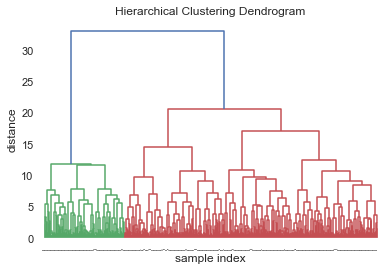

In [90]:
# Дендрограмма для МаксМин нормализации:
#linkage - массив вычислений (в 3ем столбце содержится расстоянние между кластерами)

link_norm = linkage(df_for_clust_norm, 'ward', 'euclidean')
#plt.figure(figsize=(10, 6))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dn_norm = dendrogram(link_norm, orientation = "top", leaf_font_size = 0)

#Метод Врда - сначала в обоих кластерах для всех имеющихся
#наблюдений производится расчёт средних значений отдельных переменных.
#Затем вычисляются квадраты евклидовых расстояний от отдельных наблюдений
#каждого кластера до этого кластерного среднего значения. Эти дистанции
#суммируются. Потом в один новый кластер объединяются те кластеры, которые
#дают наименьший прирост общей суммы дистанций.


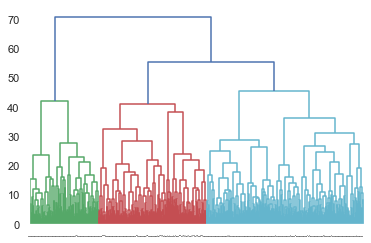

In [91]:
# Дендрограмма для z-нормализации:
# Кажется, что z-нормализация дает более хороший результат (расстояния между кластерами выходят больше)
# В дальнейшем будем работать с z-нормализацией.
link_znorm = linkage(df_for_clust_znorm, 'ward', 'euclidean')
dn_znorm = dendrogram(link_znorm, orientation = "top", leaf_font_size = 0)

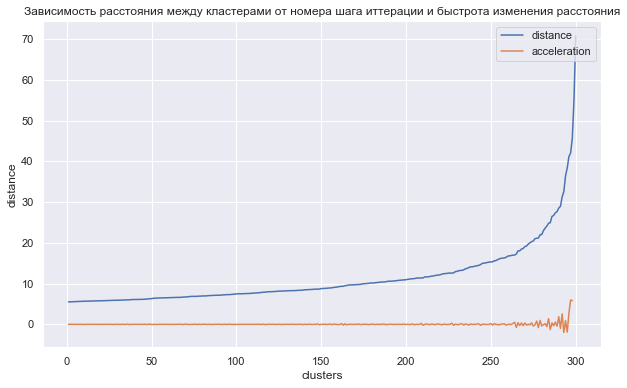

In [92]:
#На графике показана зависимость расстояния между кластерами 
#от номера шага итерации, на котором два ближайших кластера объединяются в новый. 
#Оранжевая линия показывает, как меняется ускорение - быстрота изменения расстояния между объединяемыми кластерами.

last = link_znorm[-300::, 2]
last_rev = last[::1]
idxs = np.arange(1, len(last) + 1)
plt.figure(figsize=(10, 6))
plt.plot(idxs, last_rev, label = 'distance')
acceleration = np.diff(last, 2) 
acceleration_rev = acceleration[::1]
plt.plot(idxs[:-2], acceleration_rev, label='acceleration')

plt.title('Зависимость расстояния между кластерами от номера шага иттерации и быстрота изменения расстояния')
plt.xlabel('clusters')
plt.ylabel('distance')
plt.legend(loc='upper right')


In [93]:
#Добавим к данным колонку cluster.
#Для этого используем функцию fcluster.
#Аргументы:
#1. linkage
#2. пороговое значение для расстояния между кластерами либо кол-во кластеров в зависимости от criterion
#3. maxclust для разбиения по заданному числу кластеров)

In [94]:
df_for_clust['cluster'] = fcluster(link_znorm, 3, criterion = 'maxclust')
df['cluster'] = fcluster(link_norm, 3, criterion = 'maxclust')

In [95]:
a = df[['teacher_id', 'cluster']]
b = a.drop_duplicates(subset = ['teacher_id', 'cluster'])
print('Процент учителей входящий в более чем 1 кластер=', round(len(df['teacher_id'].unique())*100/b.shape[0],2))

Процент учителей входящий в более чем 1 кластер= 44.4


In [96]:
means = df_for_clust.groupby('cluster').mean()
means_t = means.T
means_t

cluster,1,2,3
Пол (1-Ж),0.847162,0.709040,0.734496
Возраст (разбивка),2.048035,1.833333,1.955426
Страна (1-RU),0.689956,0.994350,0.771318
log(кол-во П в городе),1.149207,1.882050,1.206831
"Категория (0,1,2,3)",1.310044,1.918079,1.461240
Стаж работы П в целом (лет),7.314410,5.189266,7.422481
ОГЭ,0.021834,0.864407,0.953488
ЕГЭ,0.021834,0.516949,0.565891
ВПР,0.598253,0.785311,0.412791
Math Low knowledge,0.737991,0.796610,0.724806


In [97]:
df_for_clust.groupby('cluster').size()

cluster
1    229
2    354
3    516
dtype: int64